In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import wave
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *

In [ ]:
import tensorflow as tf

In [ ]:
def extract_mfcc(wav_file_name):
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    return mfccs

In [ ]:
from zipfile import ZipFile
# from PIL import Image
path = "/content/drive/MyDrive/speech_dataset/speech.zip"

with ZipFile(path) as f:
  f.extractall("./data")
  print("Data extracted")

Data extracted


In [25]:
radvess_speech_labels = []
ravdess_speech_data = []

for dirname, _, filenames in os.walk('/content/data'):
    for filename in filenames:
        try:
            label = int(filename[7:8]) - 1
            radvess_speech_labels.append(label)
            wav_file_name = os.path.join(dirname, filename)
            ravdess_speech_data.append(extract_mfcc(wav_file_name))
        except ValueError:
            print(f"Skipping file {filename} due to invalid label")

print("Finish Loading the Dataset")


Finish Loading the Dataset


In [ ]:
### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data)
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape

### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array)
labels_categorical.shape

(2880, 8)

In [ ]:
# print(labels_categorical[1])

In [ ]:

ravdess_speech_data_array.shape

(2880, 40)

In [ ]:

x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),labels_categorical, test_size=0.20, random_state=9)

In [ ]:
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples *0.1)

In [ ]:
def create_model_LSTM():
    model= Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
w = np.expand_dims(ravdess_speech_data_array[:training_samples],-1)

In [ ]:
w.shape

(2304, 40, 1)

In [15]:
model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=130, shuffle=True)

Epoch 1/130
72/72 [==============================] - 8s 73ms/step - loss: 2.0686 - accuracy: 0.1580 - val_loss: 2.0168 - val_accuracy: 0.2257
Epoch 2/130
72/72 [==============================] - 5s 73ms/step - loss: 2.0096 - accuracy: 0.1949 - val_loss: 1.8842 - val_accuracy: 0.2743
Epoch 3/130
72/72 [==============================] - 4s 61ms/step - loss: 1.9663 - accuracy: 0.2292 - val_loss: 1.8828 - val_accuracy: 0.2639
Epoch 4/130
72/72 [==============================] - 5s 75ms/step - loss: 1.9170 - accuracy: 0.2687 - val_loss: 1.8113 - val_accuracy: 0.3264
Epoch 5/130
72/72 [==============================] - 5s 67ms/step - loss: 1.8966 - accuracy: 0.2565 - val_loss: 1.7338 - val_accuracy: 0.3611
Epoch 6/130
72/72 [==============================] - 4s 61ms/step - loss: 1.8831 - accuracy: 0.2578 - val_loss: 1.7194 - val_accuracy: 0.3750
Epoch 7/130
72/72 [==============================] - 6s 85ms/step - loss: 1.8548 - accuracy: 0.2882 - val_loss: 1.7062 - val_accuracy: 0.3646
Epoch 

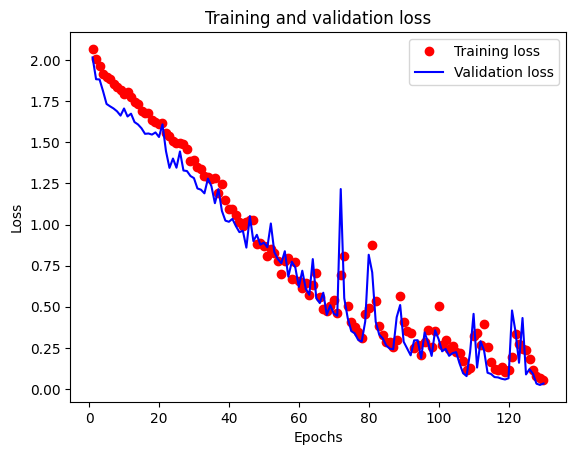

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

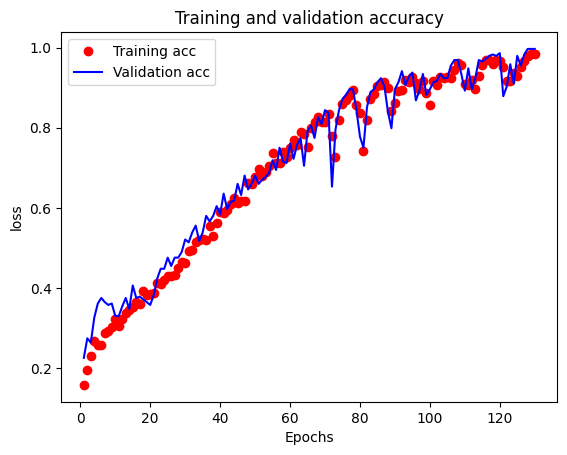

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [18]:
model_A.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], -1), labels_categorical[training_samples +validation_samples:])

9/9 [==============================] - 0s 21ms/step - loss: 3.0442 - accuracy: 0.7292


[3.0442330837249756, 0.7291666865348816]

In [19]:
emotions={1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 : 'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}
def predict(wav_filepath):
  test_point=extract_mfcc(wav_filepath)
  test_point=np.reshape(test_point,newshape=(1,40,1))
  predictions=model_A.predict(test_point)
  print(emotions[np.argmax(predictions[0])+1])

In [20]:
predict('/content/data/Actor_01/03-01-01-01-01-01-01.wav')

1/1 [==============================] - 1s 562ms/step
neutral


In [21]:
predict('/content/data/Actor_03/03-01-01-01-01-01-03.wav')

1/1 [==============================] - 0s 40ms/step
neutral


In [22]:
model_A.save('/content/drive/MyDrive/Colab Notebooks/datasets/Speech recognition major module2.h5')

In [23]:
model=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/datasets/Speech recognition major module2.h5')